# Deep Learning for Sentiment Analysis on the Yelp Dataset

## Imports

First, let's make sure that we have all the necessary libraries.

In [168]:
%pip install --upgrade tensorflow matplotlib pandas folium kaggle scikit-learn seaborn keras


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


The imports below are all ML/DL related.

In [169]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

The imports below are mostly utility imports.

In [170]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import pandas as pd
import json
import os
import math

## Data retrieval from Kaggle

Simply copy-paste your username and key below and run all the cells below to get the data.

In [4]:
os.environ['KAGGLE_USERNAME'] = "x"
os.environ['KAGGLE_KEY'] = "x"

In [5]:
!kaggle datasets download -d yelp-dataset/yelp-dataset

401 - Unauthorized


The OR (`||`) in the cells below is so that one can run all the cells multiple times, without having to worry about skipping these two (which would impede the process, seeing as they would return an error).

In [ ]:
!mkdir yelp-data || echo "Directory is ready."

In [6]:
!unzip -d yelp-data yelp-dataset.zip || echo "Data is ready."

Data is already prepared


## Data examination

### Let's define some useful functions...

In [105]:
# adjust the kwarg 'max_nl' depending on how much time you're willing to wait and how much RAM is available (leave None if you want to read the whole file)
def read_to_dataframe(file, max_nl=None):
  with open(file, 'r') as f:
    data = [json.loads(line) for line in f] if max_nl is None else [json.loads(next(f)) for _ in range(max_nl)]

  return pd.DataFrame(data)

### ...define some useful variables

In [70]:
data_dir = "yelp-data/" # splitting data up like this might be useful for later (in case i want to use other files)

### ... and turn our data into a pandas DataFrame for further examination.

In [71]:
review_file = "yelp_academic_dataset_review.json"

In [114]:
review_df = read_to_dataframe(data_dir + review_file, max_nl=100_000)

Great! Let's see what we're dealing with.

In [110]:
review_df.head() # to get an idea as to what we're dealing with

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15


It seems that the two key columns are 'stars' and 'text', the former as a label and the latter as our features. The 'useful', 'funny' and 'cool' columns also look interesting, but it seems like they're more about the review per se than the place being reviewed and are made a posteriori (i.e. after the review has already been made and the rating has been assigned, check [here](https://aghenai.github.io/assets/publications/Amira_Ghenai_Final_Report.pdf)), so we can't really use them for much.

In [81]:
review_df.drop(columns=['useful', 'funny', 'cool'], inplace=True) # it's no use carrying useless data around...

Let's get some extra information.

In [115]:
review_df.info() # all entries are non-null! 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   review_id    100000 non-null  object 
 1   user_id      100000 non-null  object 
 2   business_id  100000 non-null  object 
 3   stars        100000 non-null  float64
 4   useful       100000 non-null  int64  
 5   funny        100000 non-null  int64  
 6   cool         100000 non-null  int64  
 7   text         100000 non-null  object 
 8   date         100000 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 6.9+ MB


No nulls anywhere, wonderful news! Let's quickly check out the statistics of the stars column.

In [83]:
review_df.describe()

,stars
count,100000.000000
mean,3.842910
std,1.354729
min,1.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,5.000000


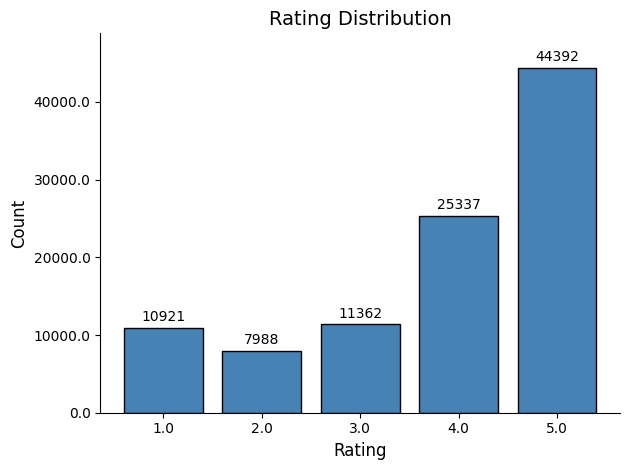

In [93]:
# sort the ratings in ascending order
sorted_ratings = review_df['stars'].value_counts().sort_index()

# Create a bar plot
fig, ax = plt.subplots()

ax.bar(sorted_ratings.index, sorted_ratings.values, color='steelblue', edgecolor='black')

# set plot title and labels
ax.set_title('Rating Distribution', fontsize=14)
ax.set_xlabel('Rating', fontsize=12)
ax.set_ylabel('Count', fontsize=12)

# customize the tick labels and axis limits
ax.set_xticks(sorted_ratings.index)
ax.set_xticklabels(sorted_ratings.index, fontsize=10)

ax.yaxis.set_major_locator(ticker.FixedLocator(ax.get_yticks()))
ax.set_yticklabels(ax.get_yticks(), fontsize=10)
ax.set_ylim(0, sorted_ratings.max() * 1.1)

# Remove spines and add grid lines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add data labels above each bar
for x, y in zip(sorted_ratings.index, sorted_ratings.values):
    ax.text(x, y + 0.02 * sorted_ratings.max(), str(y), ha='center', fontsize=10)

# Adjust the figure layout
fig.tight_layout()

# Show the plot
plt.show()


Interesting distribution. It seems that most of the reviews are positive, and a reasonable amount of them as positive as they can be!

### Let's inspect the data some more, for the fun of it.

I don't like the identifiers we're currently working with, and would rather like to see the names of the various businesses and their locations.

In [116]:
business_file = "yelp_academic_dataset_business.json"

business_df = read_to_dataframe(data_dir + business_file) # no need to set a limit (the file is 113MB large)
business_df.drop(["stars"], axis=1, inplace=True) # this is the rating of the businesses (we don't care about that)

In [117]:
rich_df = pd.merge(review_df, business_df, on="business_id")

Ok, let's see what this "rich" data gives us...

In [108]:
rich_df.head()

,review_id,user_id,business_id,stars,text,date,name,address,city,state,postal_code,latitude,longitude,review_count,is_open,attributes,categories,hours
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11,Turning Point of North Wales,1460 Bethlehem Pike,North Wales,PA,19454,40.210196,-75.223639,169,1,"{'NoiseLevel': 'u'average'', 'HasTV': 'False',...","Restaurants, Breakfast & Brunch, Food, Juice B...","{'Monday': '7:30-15:0', 'Tuesday': '7:30-15:0'..."
1,VJxlBnJmCDIy8DFG0kjSow,Iaee7y6zdSB3B-kRCo4z1w,XQfwVwDr-v0ZS3_CbbE5Xw,2.0,This is the second time we tried turning point...,2017-05-13 17:06:55,Turning Point of North Wales,1460 Bethlehem Pike,North Wales,PA,19454,40.210196,-75.223639,169,1,"{'NoiseLevel': 'u'average'', 'HasTV': 'False',...","Restaurants, Breakfast & Brunch, Food, Juice B...","{'Monday': '7:30-15:0', 'Tuesday': '7:30-15:0'..."
2,S6pQZQocMB1WHMjTRbt77A,ejFxLGqQcWNLdNByJlIhnQ,XQfwVwDr-v0ZS3_CbbE5Xw,4.0,The place is cute and the staff was very frien...,2017-08-08 00:58:18,Turning Point of North Wales,1460 Bethlehem Pike,North Wales,PA,19454,40.210196,-75.223639,169,1,"{'NoiseLevel': 'u'average'', 'HasTV': 'False',...","Restaurants, Breakfast & Brunch, Food, Juice B...","{'Monday': '7:30-15:0', 'Tuesday': '7:30-15:0'..."
3,WqgTKVqWVHDHjnjEsBvUgg,f7xa0p_1V9lx53iIGN5Sug,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,We came on a Saturday morning after waiting a ...,2017-11-19 02:20:23,Turning Point of North Wales,1460 Bethlehem Pike,North Wales,PA,19454,40.210196,-75.223639,169,1,"{'NoiseLevel': 'u'average'', 'HasTV': 'False',...","Restaurants, Breakfast & Brunch, Food, Juice B...","{'Monday': '7:30-15:0', 'Tuesday': '7:30-15:0'..."
4,M0wzFFb7pefOPcxeRVbLag,dCooFVCk8M1nVaQqcfTL3Q,XQfwVwDr-v0ZS3_CbbE5Xw,2.0,"Mediocre at best. The decor is very nice, and ...",2017-09-09 17:49:47,Turning Point of North Wales,1460 Bethlehem Pike,North Wales,PA,19454,40.210196,-75.223639,169,1,"{'NoiseLevel': 'u'average'', 'HasTV': 'False',...","Restaurants, Breakfast & Brunch, Food, Juice B...","{'Monday': '7:30-15:0', 'Tuesday': '7:30-15:0'..."


Perfect: we know get some extra information about the business. Everything is much more human readable now and ameanable to further exploration. I only intend to take a look at a geographical visualization, but the possibilites are endless. I encourage you to explore them, if you wish.

Graphically speaking, we can use the `folium` library.

In [118]:
import folium

fol_fig = folium.Figure(width=1000, height=600)

# Create a map object centered at a specific location (e.g., the geographical center of North America (we know the data is from USA and Canada))
map_obj = folium.Map(location=[39.7392, -104.9903], zoom_start=4, tiles='Stamen Toner').add_to(fol_fig)

sampled_df = rich_df.sample(n=1000) # to speed up execution (up to 1000 works fine, above that it starts to slow down significantly)
# Iterate over your dataset and add markers for each data point
for index, row in sampled_df.iterrows():
    # Extract the latitude and longtude values from your dataframe
    latitude = row['latitude']
    longitude = row['longitude']
    
    # Add a marker to the map for each data point
    folium.Marker([latitude, longitude]).add_to(map_obj)

# Display the map
map_obj

So it seems that our data is mostly made up of businesses on the east and west coasts of the USA, and then Canada. That's interesting (and not particularly surprising).

Now, onto more interesting things!

## Prepare the data 

### Let's define some useful functions...

In [123]:
def create_datasets(df, feature_columns, label_column, train_size, test_size, random_state=None):
    X = df[feature_columns]
    y = df[label_column]

    # we use stratification to mantain similar proportions across the various splits (the distribution is quite asymmetrical, after all)
    X_train, X_test_val, y_train, y_test_val = train_test_split(
        X, y, train_size=train_size, stratify=y, random_state=random_state)

    X_val, X_test, y_val, y_test = train_test_split(
        X_test_val, y_test_val, test_size=test_size, stratify=y_test_val, random_state=random_state)

    return X_train, X_val, X_test, y_train, y_val, y_test

def prepare_for_model(train_dataset, val_dataset, test_dataset, m, preprocess_fn, batch_size=64):
    # apply the preprocessing pipeline to the datasets
    train_dataset_prepepared = train_dataset.map(
        lambda review, label: (preprocess_fn(review), label))
    val_dataset_prepared = val_dataset.map(
        lambda review, label: (preprocess_fn(review), label))
    test_dataset_prepared = test_dataset.map(
        lambda review, label: (preprocess_fn(review), label))

    # shuffle and batch the training dataset
    train_dataset_prepepared = train_dataset_prepepared.shuffle(m).batch(batch_size)

    # batch the validation and testing datasets
    val_dataset_prepared = val_dataset_prepared.batch(batch_size)
    test_dataset_prepared = test_dataset_prepared.batch(batch_size)

    return train_dataset_prepepared, val_dataset_prepared, test_dataset_prepared


### ... and some useful variables, as usual.

In [124]:
vocabulary_size = 30_000
train_size = 0.7 # the percentage of data reserved for training
test_size = 0.5 # the percentage of data reserved for testing (from the data that remains)
n_epochs = 10 # adjust this if the model trains too slowly (or modify model parameters as desired...)

### Ok, now on to data preparation.

In [125]:
# only get data from the review DataFrame (the one in the rich_df is more for exploratory purposes)
X_train, X_val, X_test, y_train, y_val, y_test = create_datasets(
    review_df, 'text', 'stars', train_size, test_size, random_state=42) # the random state is set for reproducibility

print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (70000,) (70000,)
Validation set shape: (15000,) (15000,)
Testing set shape: (15000,) (15000,)


We need to make sure that the data is in a format that `tensorflow`  now can work with.

In [21]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

Also, we need to define the function we're going to use to preprocess the data and prepare it for the model, which, thanks to keras, is incredibly easy: the `TextVectorization` layer is capable of processing textual data E2E, i.e. from standardization, to tokenization and to vectorization!

In [126]:
# it's almost magical...
text_vectorization = layers.TextVectorization(
    max_tokens=vocabulary_size,
    output_mode='multi_hot',
    standardize='lower_and_strip_punctuation',
    split='whitespace',
)

Before moving on, we need to build the vocabulary, i.e. we need to fundamentally build the vector space that we'll operate in.

In [127]:
# this might take a while (~20s)
text_vectorization.adapt(train_dataset.map(lambda review, label: review))

Great, now we can finally turn the data in a format accepted by the model.

In [135]:
train_dataset_prep, val_dataset_prep, test_dataset_prep = prepare_for_model(
    train_dataset, val_dataset, test_dataset, len(X_train), text_vectorization)

Let's see if everything worked.

In [136]:
for inputs, targets in train_dataset_prep:
    print("inputs.shape:", inputs.shape)
    print("inputs.dtype:", inputs.dtype)

    print("targets.shape:", targets.shape)
    print("targets.dtype:", targets.dtype)

    print("inputs[0]:", inputs[0])
    print("targets[0]:", targets[0])
    break

2023-06-16 19:14:08.491869: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 43890 of 70000
2023-06-16 19:14:14.422477: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


inputs.shape: (64, 30000)
inputs.dtype: <dtype: 'float32'>
targets.shape: (64,)
targets.dtype: <dtype: 'float64'>
inputs[0]: tf.Tensor([0. 1. 1. ... 0. 0. 0.], shape=(30000,), dtype=float32)
targets[0]: tf.Tensor(5.0, shape=(), dtype=float64)


Looks good!

## Let's try a Bag-of-Words approach 

### As above, the first cell will contain some useful functions.

In [131]:
def plot_training_curves(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')

    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.legend()
    plt.show()

### 1-gram model

The first approach we're going to try is a simple Bag-of-Words approach, i.e. we'll treat the various tokens (in our case the single words) as sets and we'll ignore the order in which they're presented. There will be time for more complicated models later on. For now, we simply want a baseline.

In [157]:
def create_bow_model(input_dim):
    input = layers.Input(shape=(input_dim,))

    # the network below is pretty small, mostly because the previous one (which was quite a bit bigger) simply kept crashing the Colab kernel
    x = layers.Dense(256, activation='relu')(input)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    output = layers.Dense(1)(x)

    model = keras.Model(inputs=input, outputs=output)

    # I'm going to treat this as a regression problem (although it could be seens as a classification) because, as far as sentiment analysis is concerned, it should allow for a more nuanced opinion
    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mse'])

    return model

In [158]:
# the model we created is 1-gram, i.e. each word represents a single element in the set
model_1gram = create_bow_model(vocabulary_size)

In [159]:
model_1gram.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 30000)]           0         
                                                                 
 dense_32 (Dense)            (None, 256)               7680256   
                                                                 
 dropout_25 (Dropout)        (None, 256)               0         
                                                                 
 dense_33 (Dense)            (None, 128)               32896     
                                                                 
 dropout_26 (Dropout)        (None, 128)               0         
                                                                 
 dense_34 (Dense)            (None, 64)                8256      
                                                                 
 dropout_27 (Dropout)        (None, 64)                0   

In [171]:
callbacks = [
    keras.callbacks.ModelCheckpoint("model_bow_1gram.keras", save_best_only=True, options=None)
]

history_1gram = model_1gram.fit(
    # one could .cache() this data to speed up training, but I didn't do it to take up less RAM
    train_dataset_prep,
    validation_data=val_dataset_prep,
    epochs=n_epochs,
    callbacks=callbacks,
    )

Epoch 1/10


2023-06-16 19:43:33.139016: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 43777 of 70000


   8/1094 [..............................] - ETA: 19s - loss: 0.2680 - mse: 0.2680  

2023-06-16 19:43:39.222020: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1092/1094 [============================>.] - ETA: 0s - loss: 0.3012 - mse: 0.3012

ValueError: The following argument(s) are not supported with the native Keras format: ['options']

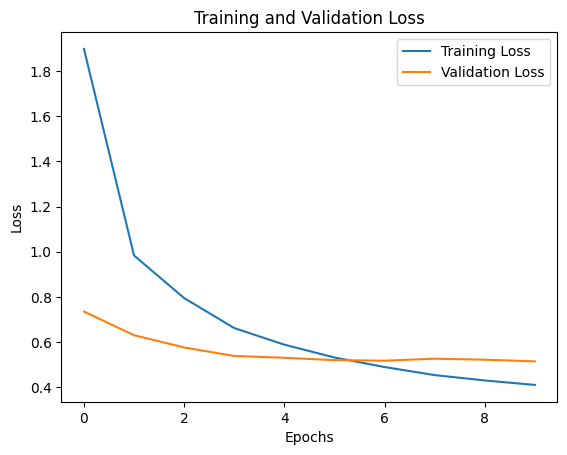

In [32]:
plot_training_curves(history_1gram)

Let's experiment with a 2-gram model!

In [33]:
# we have the very convenient TextVectorizatoin layer for preprocessing!
text_vectorization = layers.TextVectorization(
    ngrams=2, # it's that simple!
    max_tokens=vocabulary_size,
    output_mode='multi_hot',
    standardize="lower_and_strip_punctuation",
    split="whitespace",
    # the option below is only useful if output_mode is "int" (it takes care of the padding)
    # output_sequence_length=max_length,
)

In [34]:
text_vectorization.adapt(train_dataset.map(lambda review, label: review)) # build the vocabulary (might take a while...)

In [35]:
model_2gram = create_bow_model(vocabulary_size)

In [36]:
model_2gram.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 30000)]           0         
                                                                 
 dense_6 (Dense)             (None, 256)               7680256   
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 256)               65792     
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_8 (Dense)             (None, 128)               32896     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0   

In [37]:
# we're going to train on the exact same model! (to check whether using 2grams actually makes a difference)
history_2gram = fit_model(
    model_2gram, train_dataset_prep, val_dataset_prep, n_epochs)

2023-06-16 17:29:53.572505: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 46604 of 70000
2023-06-16 17:29:58.740782: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


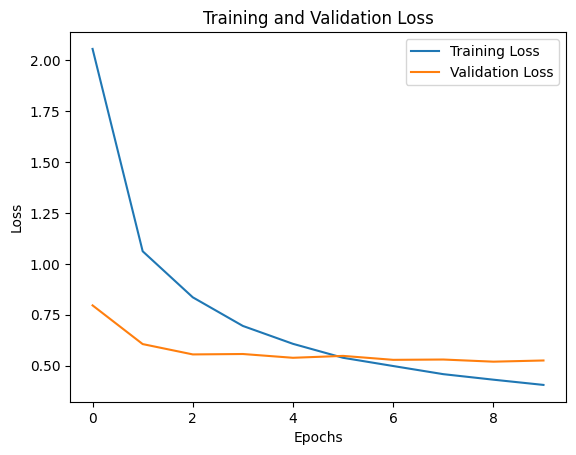

In [38]:
plot_training_curves(history_2gram)

They look quite similar.

In [39]:
# Evaluate model 1
loss_1, mse_1= model_1gram.evaluate(test_dataset_prep)
print(f"Model 1 - Test Loss: {loss_1:.4f}, MSE: {mse_1:.4f}")

# Evaluate model 2
loss_2, mse_2 = model_2gram.evaluate(test_dataset_prep)
print(f"Model 2 - Test Loss: {loss_2:.4f}, MSE: {mse_2:.4f}")


235/235 [==============================] - 5s 22ms/step - loss: 0.5222 - mse: 0.5222
Model 1 - Test Loss: 0.5222, MSE: 0.5222
235/235 [==============================] - 4s 19ms/step - loss: 0.5291 - mse: 0.5291
Model 2 - Test Loss: 0.5291, MSE: 0.5291


The 2-gram model is a bit better at evaluation time. Hurray!

In [40]:
# we have the very convenient TextVectorizatoin layer for preprocessing!
text_vectorization = layers.TextVectorization(
    ngrams=2,
    max_tokens=vocabulary_size,
    output_mode='tf_idf', # once again, it's that simple
    standardize="lower_and_strip_punctuation",
    split="whitespace",
)

In [41]:
text_vectorization.adapt(train_dataset.map(lambda review, label: review)) # build the vocabulary (might take a while...)

In [42]:
model_tfidf = create_model(vocabulary_size)

NameError: name 'create_model' is not defined

In [ ]:
model_tfidf.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30000)]           0         
                                                                 
 dense (Dense)               (None, 256)               7680256   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0     

In [ ]:
history_tfidf = fit_model(
    model_tfidf, train_dataset_prep, val_dataset_prep, n_epochs)







2023-06-11 16:33:50.839756: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 40467 of 70000
2023-06-11 16:33:58.102559: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.































































































































































































































































































































2023-06-11 16:34:31.145198: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 42002 of 70000
2023-06-11 16:34:37.920676: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.



























































































































































In [ ]:
# Evaluate the TF-IDF model
loss_tfidf, mse_tfidf = model_tfidf.evaluate(test_dataset_prep)
print(f"Model 2 - Test Loss: {loss_tfidf:.4f}, MSE: {mse_tfidf:.4f}")

235/235 [==============================] - 5s 22ms/step - loss: 0.5073 - mse: 0.5073
Model 2 - Test Loss: 0.5073, MSE: 0.5073


It seems that TF-IDF doesn't change much.

## So far we've only used textual data, why don't we use the rest?

In [ ]:
rich_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 21 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   review_id     100000 non-null  object 
 1   user_id       100000 non-null  object 
 2   business_id   100000 non-null  object 
 3   stars         100000 non-null  float64
 4   useful        100000 non-null  int64  
 5   funny         100000 non-null  int64  
 6   cool          100000 non-null  int64  
 7   text          100000 non-null  object 
 8   date          100000 non-null  object 
 9   name          100000 non-null  object 
 10  address       100000 non-null  object 
 11  city          100000 non-null  object 
 12  state         100000 non-null  object 
 13  postal_code   100000 non-null  object 
 14  latitude      100000 non-null  float64
 15  longitude     100000 non-null  float64
 16  review_count  100000 non-null  int64  
 17  is_open       100000 non-null  int64  
 18  attri

We have plenty of information, but a lot of it is useless/confounding.
 - the 'useful', 'funny' and 'cool' columns contain information about the review itself, i.e. they're obtained posterior to the stars, so we should remove them (also, check out the correlation matrix below: it's clear they matter very little)
 - the 'date' column should be eliminated to remove spurious correlations (there might be a relationship between date and stars, but it's definitely not one we want to learn, it smells of overfitting)
 - the 'name', 'address', 'city', 'state' and 'postal_code' columns should be eliminated because their information is contained in the latitude and longitude columns, so they're redundant
 - the 'is_open' column could be useful as a filtering step (i.e. we might only want to perform sentiment analysis on open businesses), but for simplification I'll drop it
 - the 'categories' column could also used as a filtering step (as it is on Kaggle, e.g. https://www.kaggle.com/code/niyamatalmass/finding-the-perfect-restaurants-on-yelp), but for simplification I'll drop it
 - the 'hours' column is as above, so I'll drop it as well

 At the end of the day we only provisionally keep the 'text', 'latitude', 'longitude', 'review_count' and 'attributes' columns for our features (and, clearly, the 'stars' column as labels)...

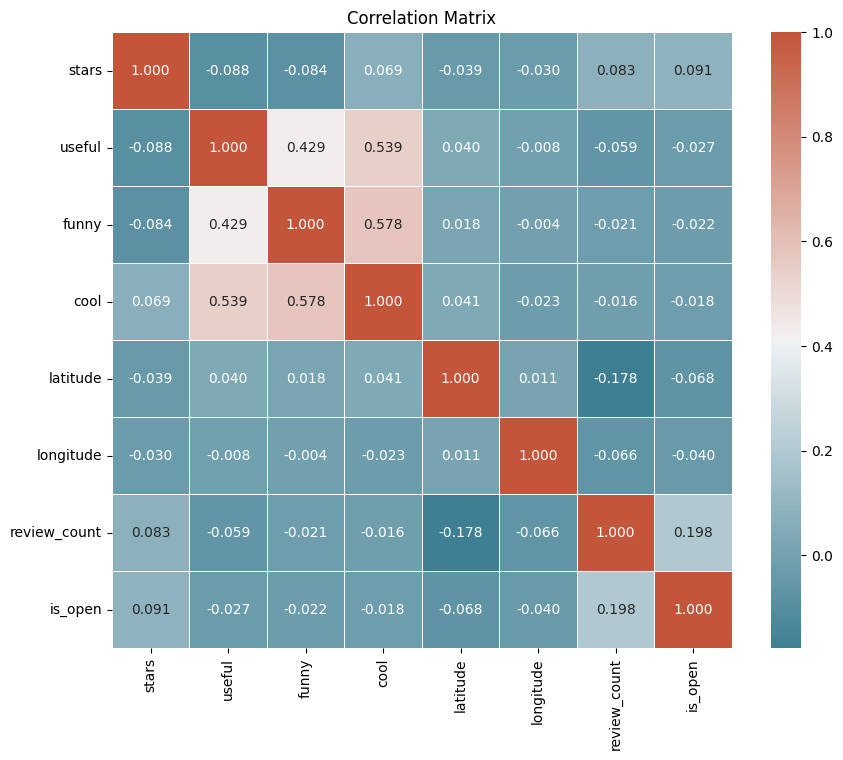

In [ ]:
# compute the correlation matrix of the various numerical attributes
numeric_columns = rich_df.select_dtypes(include=['int64', 'float64'])
# Assuming your DataFrame is named 'df'
corr_matrix = numeric_columns.corr()

# Set the color palette
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Plot the correlation matrix with highlighted 'stars' column
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap=cmap, annot=True, fmt=".3f", linewidths=0.5, cbar=True)
plt.title("Correlation Matrix")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()


It seems like the review_count, latitude and longitude columns are not that significant... Let's check it with a scatter plot.

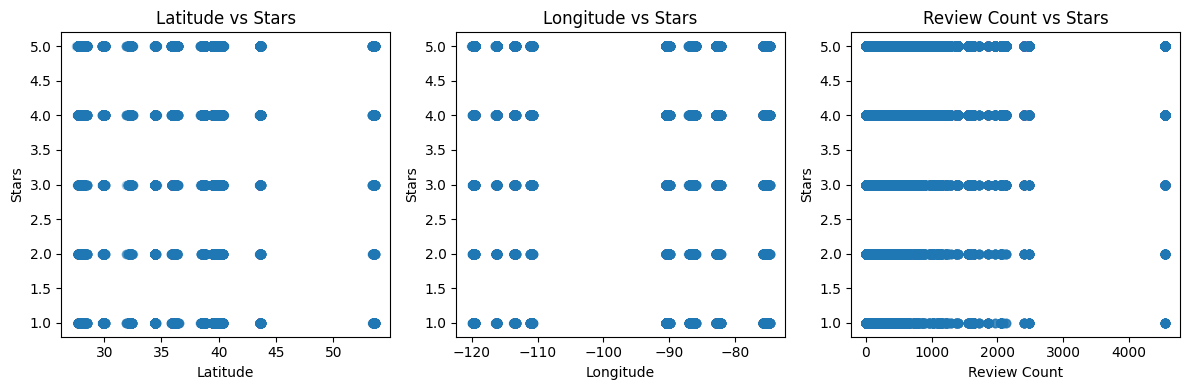

In [ ]:
# Create a scatter plot for latitude vs stars
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(rich_df['latitude'], rich_df['stars'], alpha=0.3)
plt.xlabel('Latitude')
plt.ylabel('Stars')
plt.title('Latitude vs Stars')

# Create a scatter plot for longitude vs stars
plt.subplot(132)
plt.scatter(rich_df['longitude'], rich_df['stars'], alpha=0.3)
plt.xlabel('Longitude')
plt.ylabel('Stars')
plt.title('Longitude vs Stars')

# Create a scatter plot for review_count vs stars
plt.subplot(133)
plt.scatter(rich_df['review_count'], rich_df['stars'], alpha=0.3)
plt.xlabel('Review Count')
plt.ylabel('Stars')
plt.title('Review Count vs Stars')

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

# => they all seem to not matter much at all (as hinted at by the correlation matrix)

In [ ]:
X = rich_df[['text', 'attributes']]
y = rich_df['stars']

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   text        100000 non-null  object
 1   attributes  98369 non-null   object
dtypes: object(2)
memory usage: 1.5+ MB


The 'attributes' column looks extremely interesting to me, and I already have an interesting idea as to how to use it (i.e. learn some embeddings based on its contents and substitute the column with these embeddings). But, to avoid useless work, it's a good idea to try to estimate its importance, or at least its viability in our context.

In [ ]:
# it contains JSON objects, it seems, with two level of nesting and all attributes are textual (i.e. categorical)
X.iloc[0].attributes

{'NoiseLevel': "u'average'",
 'HasTV': 'False',
 'RestaurantsAttire': "'casual'",
 'BikeParking': 'False',
 'Ambience': "{'touristy': False, 'hipster': False, 'romantic': False, 'divey': False, 'intimate': False, 'trendy': False, 'upscale': False, 'classy': False, 'casual': True}",
 'WiFi': "'free'",
 'DogsAllowed': 'False',
 'Alcohol': "'none'",
 'BusinessAcceptsCreditCards': 'True',
 'RestaurantsGoodForGroups': 'True',
 'RestaurantsPriceRange2': '2',
 'RestaurantsReservations': 'False',
 'WheelchairAccessible': 'True',
 'BusinessAcceptsBitcoin': 'False',
 'RestaurantsTableService': 'True',
 'GoodForKids': 'True',
 'Caters': 'False',
 'HappyHour': 'False',
 'RestaurantsDelivery': 'True',
 'GoodForMeal': "{'dessert': False, 'latenight': False, 'lunch': True, 'dinner': False, 'brunch': True, 'breakfast': True}",
 'OutdoorSeating': 'True',
 'RestaurantsTakeOut': 'True',
 'BusinessParking': "{'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}"}

In [ ]:
# let's try to flatten the column and see what we're working with...
def flatten_json_columns(df, columns):
    for col in columns:
        df_normalized = pd.json_normalize(df[col])
        df = df.drop(columns=[col])
        df = pd.concat([df, df_normalized], axis=1)
    return df

# Assuming 'df' is your pandas DataFrame
# First level of normalization on 'attributes' column
X = flatten_json_columns(X, ['attributes'])

# Second level of normalization on nested columns
X = flatten_json_columns(
    X, ['Ambience', 'GoodForMeal', 'BusinessParking'])

In [ ]:
# that added a LOT of new columns, and most of them containing plenty of nulls (i.e. check out the RestaurantsCounterService column!)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 37 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   text                        100000 non-null  object
 1   NoiseLevel                  73115 non-null   object
 2   HasTV                       72629 non-null   object
 3   RestaurantsAttire           70807 non-null   object
 4   BikeParking                 83583 non-null   object
 5   WiFi                        80187 non-null   object
 6   DogsAllowed                 42427 non-null   object
 7   Alcohol                     73054 non-null   object
 8   BusinessAcceptsCreditCards  94663 non-null   object
 9   RestaurantsGoodForGroups    72738 non-null   object
 10  RestaurantsPriceRange2      90112 non-null   object
 11  RestaurantsReservations     72372 non-null   object
 12  WheelchairAccessible        36623 non-null   object
 13  BusinessAcceptsBitcoin      21

In [ ]:
null_counts = X.isnull().sum()
sorted_columns = null_counts.sort_values() # sort columns based on number of null values in each

X[sorted_columns.index].info() # by the 18th column we're already at 60% of values being null!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 37 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   text                        100000 non-null  object
 1   BusinessAcceptsCreditCards  94663 non-null   object
 2   RestaurantsPriceRange2      90112 non-null   object
 3   BikeParking                 83583 non-null   object
 4   WiFi                        80187 non-null   object
 5   GoodForKids                 77828 non-null   object
 6   RestaurantsTakeOut          77366 non-null   object
 7   RestaurantsDelivery         75632 non-null   object
 8   OutdoorSeating              74694 non-null   object
 9   NoiseLevel                  73115 non-null   object
 10  Alcohol                     73054 non-null   object
 11  RestaurantsGoodForGroups    72738 non-null   object
 12  HasTV                       72629 non-null   object
 13  RestaurantsReservations     72

At this point we have two choices: we either leave the attributes in (and preprocess them, embed them, etc. as specified above) or we dont. I'll opt for the second choice because 1. I don't have access to a lot of compute and training embeddings could be quite compute intensive 2. Intuitively speaking, a lot of this information should be in the review text itself, so the model probably already takes that into account when trying to predict a rating. So? It seems our initial approach of only utilising the text was a reasonable one and that no further feature engineering is necessary.

This is comforting and also more interesting: using only the text makes the problem more challenging and has a good change of improving out-of-distribution performance anyhow, because we literally have no other variables to think about!

## Time to get serious: let's use RNNs!

### Let's quickly go through the data preparation steps (all explained above)...

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = create_datasets(
    'text', 'stars', train_size, test_size, random_state=42)

print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

# Create TensorFlow datasets for the training, validatoin and test data
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

max_length = max(rich_df['text'].apply(lambda x: len(x.split())))

text_vectorization = layers.TextVectorization(
    max_tokens=vocabulary_size,
    output_mode="int",
    standardize="lower_and_strip_punctuation",
    split="whitespace",
    output_sequence_length=max_length,
)

text_vectorization.adapt(train_dataset.map(lambda review, label: review)) # build the vocabulary (might take a while...)

train_dataset_prep, val_dataset_prep, test_dataset_prep = prepare_for_model(
    train_dataset, len(X_train), val_dataset, test_dataset, text_vectorization)

Training set shape: (70000,) (70000,)
Validation set shape: (15000,) (15000,)
Testing set shape: (15000,) (15000,)


### On to defining our models and training them...

In [ ]:
# we expect to benefit from an RNN based model because the improvement we saw with 2-grams indicates that the local structure is important!
def create_LSTM_model(max_length, num_words):
    inputs = layers.Input(shape=(max_length,), dtype="int64")
    one_hot = tf.one_hot(inputs, depth=num_words)

    lstm = layers.Bidirectional(layers.LSTM(32))(one_hot)
    outputs = layers.Dense(1)(lstm)
    
    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='mean_squared_error',
        metrics=['mse'])
    
    return model

In [ ]:
lstm_model = create_LSTM_model(max_length, vocabulary_size)

In [ ]:
lstm_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 1006)]            0         
                                                                 
 tf.one_hot_7 (TFOpLambda)   (None, 1006, 30000)       0         
                                                                 
 bidirectional_4 (Bidirecti  (None, 64)                7688448   
 onal)                                                           
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 7688513 (29.33 MB)
Trainable params: 7688513 (29.33 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint("one_hot_bidir_lstm.keras",
                                    save_best_only=True)
]

# so this takes A LOT longer...
history = lstm_model.fit(
    train_dataset_prep,
    validation_data=val_dataset_prep, 
    epochs=5,
    callbacks=callbacks)

Epoch 1/5


KeyboardInterrupt: 

Training a bidirectional LSTM model (even one as simple as the one we created) takes much, much more time thant it does for the fully connected FFN above... There's one hope though, suggested to us by Chollet in his DL book: we could achieve a similar effect using Conv1D layers! Let's try it out.

In [ ]:
def create_conv1d_model(max_length, num_words):
    inputs = layers.Input(shape=(max_length,), dtype="int64")
    one_hot = tf.one_hot(inputs, num_words)
    conv1d = layers.Conv1D(32, 3, activation='relu')(one_hot)
    pool = layers.GlobalMaxPooling1D()(conv1d)
    outputs = layers.Dense(1)(pool)
    
    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='mean_squared_error',
        metrics=['mse'])
    
    return model

In [ ]:
conv1d_model = create_conv1d_model(max_length, vocabulary_size)

In [ ]:
conv1d_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 1006)]            0         
                                                                 
 tf.one_hot_9 (TFOpLambda)   (None, 1006, 30000)       0         
                                                                 
 conv1d (Conv1D)             (None, 1004, 32)          2880032   
                                                                 
 global_max_pooling1d (Glob  (None, 32)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2880065 (10.99 MB)
Trainable params: 2880065 (10.99 MB)
Non-trainable params: 0 (0.00 Byte)
___________________

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint("one_hot_conv1d.keras",
                                    save_best_only=True)
]

# that's quite a bit better!
history = conv1d_model.fit(
    train_dataset_prep,
    validation_data=val_dataset_prep, 
    epochs=5,
    callbacks=callbacks)

Epoch 1/5
  19/1094 [..............................] - ETA: 1:19:08 - loss: 15.7391 - mse: 15.7391

KeyboardInterrupt: 

The training has sped up considerably, but it still takes quite some time. We can speed it up further by using word embeddings!

In [ ]:
def create_conv1d_embed_model(max_length, num_words):
    inputs = layers.Input(shape=(max_length,), dtype="int64")

    embed = layers.Embedding(input_dim=num_words, output_dim=256)(inputs) # let's make it trainable!
    conv1d = layers.Conv1D(32, 3, activation='relu')(embed)
    pool = layers.GlobalMaxPooling1D()(conv1d)

    outputs = layers.Dense(1)(pool)
    
    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='mean_squared_error',
        metrics=['mse'])
    
    return model

In [ ]:
conv1d_embed_model = create_conv1d_embed_model(max_length, vocabulary_size)

In [ ]:
conv1d_embed_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1006)]            0         
                                                                 
 embedding (Embedding)       (None, 1006, 256)         7680000   
                                                                 
 conv1d (Conv1D)             (None, 1004, 32)          24608     
                                                                 
 global_max_pooling1d (Glob  (None, 32)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 7704641 (29.39 MB)
Trainable params: 7704641 (29.39 MB)
Non-trainable params: 0 (0.00 Byte)
_____________________

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint("one_hot_conv1d.keras",
                                    save_best_only=True)
]

# much better!
history = conv1d_embed_model.fit(
    train_dataset_prep,
    validation_data=val_dataset_prep, 
    epochs=5,
    callbacks=callbacks)

Epoch 1/5
 288/1094 [======>.......................] - ETA: 53s - loss: 2.0861 - mse: 2.0861

KeyboardInterrupt: 

## That didn't go so well. Let's try Transformers!

### For the n-th time, quick data preparation...

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = create_datasets(
    'text', 'stars', train_size, test_size, random_state=42)

print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

# Create TensorFlow datasets for the training, validatoin and test data
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

max_length = max(rich_df['text'].apply(lambda x: len(x.split())))

text_vectorization = layers.TextVectorization(
    max_tokens=vocabulary_size,
    output_mode="int",
    standardize="lower_and_strip_punctuation",
    split="whitespace",
    output_sequence_length=max_length,
)

text_vectorization.adapt(train_dataset.map(lambda review, label: review)) # build the vocabulary (might take a while...)

train_dataset_prep, val_dataset_prep, test_dataset_prep = prepare_for_model(
    train_dataset, len(X_train), val_dataset, test_dataset, text_vectorization)

Training set shape: (70000,) (70000,)
Validation set shape: (15000,) (15000,)
Testing set shape: (15000,) (15000,)


The code below is taken from Chollet DL book.

In [ ]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, n_heads, **kwargs):
        super().__init__(**kwargs)

        self.embed_dim = embed_dim # size of input tokens
        self.dense_dim = dense_dim # size of inner dense layer
        self.n_heads = n_heads

        self.attention = layers.MultiHeadAttention(
            num_heads=n_heads, key_dim=embed_dim)

        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
            layers.Dense(embed_dim),]
        )

        self.layernorm_1 = layers.LayerNormalization() # works better than BatchNormalization, for textual data
        self.layernorm_2 = layers.LayerNormalization()

    # The call function does the actual computation, i.e. it's called when we do TransformerEncoder(...).
    def call(self, inputs, mask=None): 
        if mask is not None:
            # the Embedding layer will create a 2D mask, the attention layer needs it to be 3D or 4D 
            mask = mask[:, tf.newaxis, :]

        # the code below simply passes the input through all the components of the encoder, as specified by the diagram
        attention_output = self.attention(inputs, inputs, attention_mask=mask)

        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)

        return self.layernorm_2(proj_input + proj_output)

    # The get_config function serves serialization purposes, i.e. allows us to save and load the model.
    def get_config(self):
        config = super().get_config() 

        config.update({
            "embed_dim": self.embed_dim,
            "n_heads": self.n_heads,
            "dense_dim": self.dense_dim,
        })

        return config

In [ ]:
def create_transformer_model(vocabulary_size, embed_dim, n_heads, dense_dim):
    inputs = keras.Input(shape=(None,), dtype="int64")

    x = layers.Embedding(vocabulary_size, embed_dim)(inputs)
    x = TransformerEncoder(embed_dim, dense_dim, n_heads)(x)
    x = layers.GlobalMaxPooling1D()(x) # the encoder will return sequences, but we need a single vector, so we flatten the seq with a pooling layer
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(1)(x)

    model = keras.Model(inputs, outputs)

    model.compile(optimizer="adam",
                loss="mean_squared_error",
                metrics=["mse"])

    return model

In [ ]:
transformer_model = create_transformer_model(vocabulary_size, 256, 2, 32)

In [ ]:
transformer_model.summary() # even with a single transformer encoder we get 8M parameters!

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 256)         7680000   
                                                                 
 transformer_encoder_1 (Tra  (None, None, 256)         543776    
 nsformerEncoder)                                                
                                                                 
 global_max_pooling1d (Glob  (None, 256)               0         
 alMaxPooling1D)                                                 
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 257   

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint("transformer_encoder.keras",
                                    save_best_only=True)
]

# slow, but still faster than biderectional RNNs!
transformer_history = transformer_model.fit(
    train_dataset_prep,
    validation_data=val_dataset_prep,
    epochs=n_epochs,
    callbacks=callbacks)

Epoch 1/10
  10/1094 [..............................] - ETA: 41:15 - loss: 8.1746 - mse: 8.1746

KeyboardInterrupt: 

We've completely ignored positional information! We can easily remedy this, though.

In [ ]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)

        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        # this will keep track of position
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)

        self.sequence_length = sequence_length 
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)

        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)

        # add both embeddings => i.e. add positional information to our tokens
        return embedded_tokens + embedded_positions

    # This function allows use to compute a mask, which in turn allows us to save on computation (we don't do anythin when this mask is zero, so we don't need to process the padding).
    # It will be called automatically and managed by keras.
    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config() 

        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })

        return config


In [ ]:
def create_pos_transformer_model(vocabulary_size, max_length, embed_dim, n_heads, dense_dim):
    inputs = keras.Input(shape=(None,), dtype="int64")

    x = PositionalEmbedding(max_length, vocabulary_size, embed_dim)(inputs)
    x = TransformerEncoder(embed_dim, dense_dim, n_heads)(x)
    x = layers.GlobalMaxPooling1D()(x) # the encoder will return sequences, but we need a single vector, so we flatten the seq with a pooling layer
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(1)(x)

    model = keras.Model(inputs, outputs)

    model.compile(optimizer="adam",
                loss="mean_squared_error",
                metrics=["mse"])

    return model

In [ ]:
pos_transformer_model = create_pos_transformer_model(vocabulary_size, max_length, 256, 2, 32)

In [ ]:
pos_transformer_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None)]            0         
                                                                 
 positional_embedding_1 (Po  (None, None, 256)         7937536   
 sitionalEmbedding)                                              
                                                                 
 transformer_encoder_2 (Tra  (None, None, 256)         543776    
 nsformerEncoder)                                                
                                                                 
 global_max_pooling1d_1 (Gl  (None, 256)               0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                           

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint("pos_transformer_encoder.keras",
                                    save_best_only=True)
]

# adding the positional embedding only makes the model a little slower, good news!
pos_transformer_history = pos_transformer_model.fit(
    train_dataset_prep,
    validation_data=val_dataset_prep,
    epochs=n_epochs,
    callbacks=callbacks)

Epoch 1/10
   4/1094 [..............................] - ETA: 42:23 - loss: 16.1593 - mse: 16.1593

KeyboardInterrupt: 